In [1]:
import torch
import pandas as pd
import numpy as np
import sys 
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
sys.path.append("./")
from prediction.api import *
from prediction.data_wrapper import get_loaders
from pickle import dump
import torch.nn.functional as F

In [2]:
args.data = './data/processed/processed_cleaned_df_2.csv'
args.input_size = [33]
args.hidden_size = 100
args.number_of_layers = 1
args.output_size = [1]
args.test_portion = 0.2 
args.train_window = 12
args.batch_size = 64
args.learning_rate = 0.001
args.weight_decay = 0.0001
args.gpu = 0 
args.epochs = 100
args.log_freq = 30
args.debug = False
args.seed = 1
args.samples = 20
args.dropout = 0.3

In [3]:
model, scaler = get_model()
print(model)

Network(
  (lstm): LSTM(33, 100, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


/home/killko/Desktop/aihack2020/venv/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [4]:
df = pd.read_csv(args.data).iloc[:,1:]

print(df.head())

      GPs  month      07    0304   0411  050103  131002   010305       01  \
0  A81001      1  7271.0  4071.0  758.0  1476.0   185.0  13032.0  69503.0   
1  A81001      2  8527.0  4071.0  758.0  1427.0   191.0  12740.0  78753.0   
2  A81001      3  6402.0  3928.0  758.0  1278.0   198.0  11574.0  65473.0   
3  A81001      4  7295.0  4836.0  758.0  1537.0   231.0  13019.0  74436.0   
4  A81001      5  6671.0  5153.0  758.0  1436.0   280.0  11824.0  65084.0   

       05  ...  030401       13           12     0106     1302       10  \
0  9767.0  ...  4310.0  59472.0   886.000000  19797.0  49930.0  15657.0   
1  9767.0  ...  4064.0  59472.0   994.666667  24304.0  49930.0  12903.0   
2  9767.0  ...  3928.0  59472.0  1103.333333  20416.0  44955.0  13236.0   
3  9767.0  ...  4836.0  58722.0  1212.000000  24713.0  45005.0  14082.0   
4  9767.0  ...  5152.0  57972.0   817.000000  20309.0  42955.0  12972.0   

    130201  050108    0603   010604  
0  41880.0   998.0  4034.0  10939.0  
1  48830.0

In [5]:
data = df.to_numpy()
gps = data[:,0]
features = data[:,1:]
label_index = df.columns.get_loc('0301')

In [6]:
print(features.shape, gps.shape)

(394458, 33) (394458,)


In [7]:
total_size = len(features)
test_size = int(args.test_portion * total_size)

test_data = features[:test_size]

test_gps = gps[:test_size]

test_unique_gps = np.unique(test_gps)
test_data_normalized = scaler.transform(test_data)
test_data_normalized = torch.FloatTensor(test_data_normalized)

In [8]:
def create_inout_sequences(input_data,_gps,_unique_gps,_label_index, tw):
    X = []
    Y = []
    counter = 0
    for i in tqdm(range(len(input_data)-tw-1)):
        seq = input_data[i:i+tw]
        label = input_data[i+tw:i+tw+1,_label_index]
        if counter == 57:
            counter = 0
            continue
        seq = np.array(seq, dtype=np.float32)
        label = np.array(label, dtype = np.float32)
        X.append(torch.from_numpy(seq).float())
        Y.append(torch.from_numpy(label).float())
        counter+=1

    return X, Y
X_test, Y_test = create_inout_sequences(test_data_normalized, test_gps, test_unique_gps, label_index, args.train_window)

100%|██████████| 78878/78878 [00:01<00:00, 52590.26it/s]


In [9]:
X_test = torch.stack(X_test)
Y_test = torch.stack(Y_test)
print(X_test.shape, Y_test.shape)

torch.Size([77519, 12, 33]) torch.Size([77519, 1])


[-1.         -0.9999188  -0.99983764 ...  0.61490685  0.64064467
  0.7274388 ]


Text(0.5, 1.0, 'Drug prescription 10')

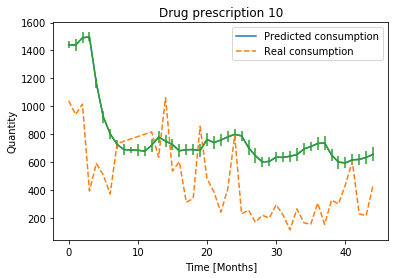

In [10]:
outs = []
golden_outs = []
stds = []
model.train()
print(np.unique(Y_test))
for i in range(40000,40045):
    feature_vector = X_test[i,:]
    ys = []
    for sample in range(args.samples):
        y = model(feature_vector.unsqueeze(dim=0))
        f = torch.zeros((1, args.input_size[0])).t()
        f[label_index] = y.item()
        y_transformed = float(scaler.inverse_transform(f.t()).reshape(-1)[label_index])
        ys.append(torch.tensor([y_transformed]))
    ys = torch.stack(ys)
    outs.append(torch.mean(ys).item())
    stds.append(torch.std(ys).item())
    f = torch.zeros((1, args.input_size[0])).t()
    f[label_index] = Y_test[i]
    golden_outs.append(scaler.inverse_transform(f.t()).reshape(-1)[label_index])

plt.plot(outs, label="Predicted consumption")
plt.plot(golden_outs, '--', label ="Real consumption")
x = np.arange(len(outs))
plt.errorbar(x = x, y=outs, yerr = [s*2 for s in stds])
plt.legend()
plt.xlabel("Time [Months]")
plt.ylabel("Quantity")
plt.title("Drug prescription {}".format(label_index))


In [11]:
mse = 0.0
std = 0.0
for i in range(len(X_test[:1000])):
    ys = []
    for sample in range(args.samples):
        y = model(X_test[i].unsqueeze(dim=0))
        f = torch.zeros(1,args.input_size[0])
        f[0,label_index] = y.item()
        y_pred = torch.tensor([float(scaler.inverse_transform(f).reshape(-1)[label_index])])
        ys.append(y_pred)

    y = torch.stack(ys).mean()
    std += torch.stack(ys).std()
    f = torch.zeros(1,args.input_size[0])
    f[0,label_index] = Y_test[i]
    y = torch.tensor([float(scaler.inverse_transform(f).reshape(-1)[label_index])])

    mse+=F.mse_loss(y_pred, y)
std/=len(X_test[:1000])
mse/=len(X_test[:1000])
print("MSE: {}".format(mse))
print("Std: {}".format(std))


MSE: 518237.21875
Std: 16.325048446655273
